In [2]:
import pandas as pd

In [160]:
df = pd.read_csv('BBC News Train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### Exploring The text data

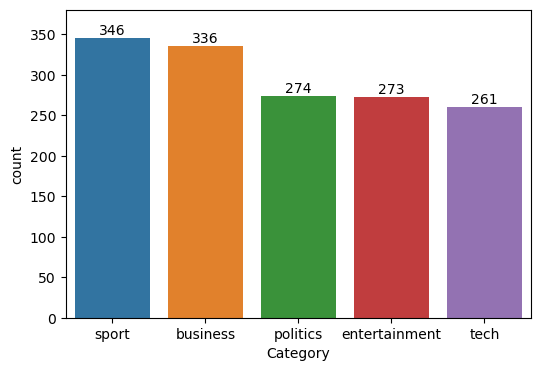

In [161]:
categories = df.Category.value_counts().to_frame().reset_index().set_axis(['Category', 'count'], axis= 1)
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=categories['Category'], y=categories['count'], ax=ax)
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.show()

In [162]:
# Remove duplicates
with_duplicates = df.shape[0]
df = df.drop_duplicates(subset='Text')
without_duplicates = df.shape[0]

In [163]:
print('Removed {} duplicate rows'.format(with_duplicates-without_duplicates))

Removed 50 duplicate rows


### Preprocessor

- To convert the text to TFIDF matrix
- This will then be exposed to classification techiques

In [164]:
#importing nltk library components for preprocessing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

In [165]:
def text_cleaner(text):
    # Removing unwanted text:
    # Replace digits and single letters
    pattern = r'\b([a-zA-Z])\b|\d+|[.,!?()-\:]'
    text = re.sub(pattern, '', text)

    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    # Removing punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    ps = PorterStemmer()
    tokens_stemmed = [ps.stem(word) for word in tokens]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    # print("Tokens:", tokens)
    # print("Stemmed Tokens:", tokens_stemmed)
    # print("Lemmatized Tokens:", tokens_lemmatized)
    text = ' '.join(tokens_lemmatized)
    return text

# def text_cleaner(df_to_clean):
#     for i,text in enumerate (df_to_clean['Text']):
#         df_to_clean['Text'][i] = text_cleaning_string(text)
#     print(df_to_clean)
#     return df_to_clean


In [166]:
# Clean the DF texts completely
# To be applied to test data also

# df['Text'] = text_cleaner(df)

#### Build a class to preprocess data and compute vectorizeed matrix representing word counts with tf-idf
- A class is created to save generate vectorized matrix for train, cross validation and test sets. This class also contains some helper functions for plotting, fitting, and predicting.

In [167]:
from sklearn import metrics
class MyData(object):
    """
    Represent text data as a sparse matrix with TfidfVectorizer
    Note: This class does not follow sklearn syntax. 
    """
    def __init__(self,df,TfidfVec=None,clean_text=True,**TtdifVec_kwargs):
        """
        Inputs:
        -df: a DataFrame including column "Text"
        -TfidfVec: previously fitted TfidfVectorizer object (pass None for a new fit)        
        -clean_text: if True, 'Text' column will be cleaned.
        -TtdifVec_kwargs: parameters to pass when the TfidfVectorizer is created
        Fields:
        -MyData.words: list of words used by TfidfVec
        -MyData.tv: fitted TfidfVectorizer object
        -MyData.WC2: Sparse matrix representation of the text
        """
        self.df = df.copy()
        if clean_text:
            self.clean_text()
        self.get_WC2(TfidfVec,**TtdifVec_kwargs)
    def clean_text(self):
            self.df['Text'] = self.df['Text'].apply(lambda x: text_cleaner(x))
    def get_WC2(self,TfidfVec=None,**TtdifVec_kwargs):
        """
        Fit TfidfVectorizer to text and return a sparse matrix from tf-idf
        """
        if TfidfVec is None:
            # This is fit only done with the training data set.
            if len(TtdifVec_kwargs)==0:
                # Fit with default parameters
                self.tv = TfidfVectorizer(min_df=0.004,max_df=0.417)  
            else:
                # Fit with user defined parameters
                self.tv = TfidfVectorizer(**TtdifVec_kwargs)
                
            self.WC2 = self.tv.fit_transform(self.df['Text'])
        else:
            # The user passed the training TfidfVectorizer object
            self.tv = TfidfVec  
            self.WC2 = self.tv.transform(self.df['Text'])
        self.words = self.tv.get_feature_names_out()                   
 
    def get_WC2_as_df(self):
        """Converts the sparse matrix WC2 into a full DataFrame"""
        return pd.DataFrame(self.WC2.A,columns=self.words)
    def __repr__(self):
        return "MyData( nwords={} )".format(self.WC2.shape)
    def __str__(self):
        return  self.__repr__()

    @staticmethod
    def plot_confusion_matrix(y_true,y_pred,title='Confusion Matrix'):        
        labels = list(set(y_pred).union(set(y_true)))        
        cm = metrics.confusion_matrix(y_true,y_pred,labels=labels)
        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt='g',ax=ax);
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title(title); 
        ax.xaxis.set_ticklabels(labels); ax.ya

In [168]:
train_df = pd.read_csv('BBC News Train.csv').drop_duplicates(subset='Text')
test_df = pd.read_csv('BBC News Test.csv') 

from sklearn.model_selection import train_test_split 
train_df, crossval_df = train_test_split(train_df,stratify=train_df[['Category']],test_size=0.2,random_state = 310)

train_data = MyData(train_df)
crossval_data = MyData(crossval_df,train_data.tv)
test_data = MyData(test_df,train_data.tv)
print('WC2 in training data set has size:',train_data.WC2.shape)
print('WC2 in crossval_data data set has size:',crossval_data.WC2.shape)
print('WC2 in test_data data set has size:',test_data.WC2.shape)

WC2 in training data set has size: (1152, 5376)
WC2 in crossval_data data set has size: (288, 5376)
WC2 in test_data data set has size: (735, 5376)


### NMF interpretation

WC(Word count matrix) = [n x m] n = no of docs, m = word count this matrix has normalized weight of words in the doc
By factorization we get W x H = WC, with k topics

W = [n x k]
H = [k x m] 

- W represents weight of topic in the doc and
- H represents weight of weight of word in the topic


In [169]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
import numpy as np

n_topics = len(train_df.Category.value_counts())
model = NMF(n_topics)
W_train = model.fit_transform(train_data.WC2)
H_train = model.components_

train_df['predicted_id'] = [np.argmax(article) for article in W_train]

In [170]:
cat_id_map = dict(train_df.pivot_table(index='Category', columns='predicted_id', aggfunc = 'size').fillna(0).apply(lambda x:np.argmax(np.array(x)), axis = 1).reset_index().rename(columns = {0:'cat_id'}).values)
cat_id_map

{'business': 2, 'entertainment': 3, 'politics': 0, 'sport': 1, 'tech': 4}

In [171]:
train_df['cat_id'] = train_df['Category'].map(cat_id_map)

In [172]:
train_df

,ArticleId,Text,Category,predicted_id,cat_id
633,1805,dublin hi-tech labs to shut down dublin s hi-t...,tech,4,4
457,1717,regiments group in poll move a regiments cam...,politics,0,0
1233,555,bnp leader nick griffin arrested the leader of...,politics,0,0
1372,557,barbarians 19-47 new zealand new zealand prove...,sport,1,1
489,563,cable offers video-on-demand cable firms ntl a...,tech,4,4
...,...,...,...,...,...
625,814,us budget deficit to reach $368bn the us budge...,business,2,2
1093,70,indonesia declines debt freeze indonesia no ...,business,2,2
1068,825,prime minister s questions so who if anyone ...,politics,0,0
470,1686,de niro completes box office coup robert de ni...,entertainment,3,3


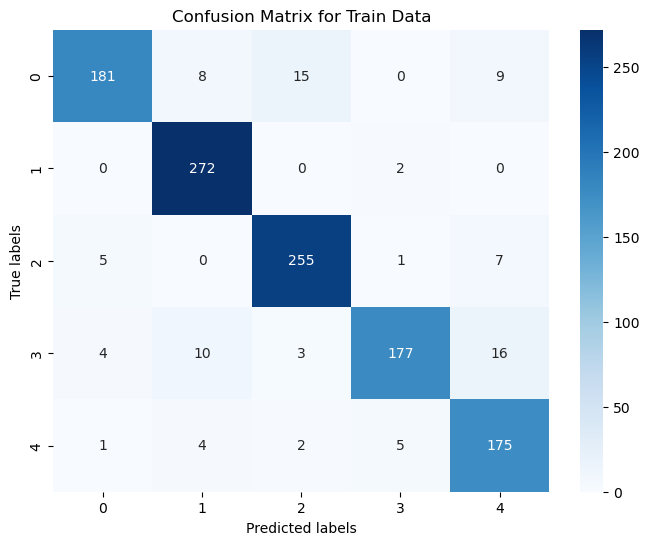

Accuracy = 92.01%


In [173]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_true = np.array(train_df['cat_id'])
y_pred = np.array(train_df['predicted_id'])

cm = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Train Data')
plt.show()

print('Accuracy = {}%'.format(round(accuracy_score(y_true,y_pred)*100,2)))

In [174]:
W_test = model.transform(test_data.WC2)

out_check = [np.argmax(article) for article in W_test]
cat_id_map
inverted_map = {v: k for k, v in cat_id_map.items()}
inverted_map

test_df['Category'] = [inverted_map[i] for i in out_check]


In [175]:
test_df

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport
...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,business
731,373,u2 to play at grammy awards show irish rock ba...,entertainment
732,1704,sport betting rules in spotlight a group of mp...,tech
733,206,alfa romeos to get gm engines fiat is to sto...,business


In [176]:
submission_df = test_df[['ArticleId','Category']]

## Kaggle Score: 91.972%
- This is a good score considering we used a completely unsupervised learning approach to the model
- Supervised methods could be tried after all improvements are done to the model
### Next Steps
- Improve preprocessing to n-grams to improve the model
